In [1]:
import itertools
import matplotlib.pyplot as plt
from brian2.only import *

# for the IDE:
import numpy_ as np
import spatial, model, inputs, readout

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes
from plot_utils import colors


rng = np.random.default_rng(368741)

N = 100
inhibitory_ratio = .2

from conf.params import params
params.update({
    # # Population size
    # 'N': N,
    # 'N_exc': int((1-inhibitory_ratio) * N),
    # 'N_inh': int(inhibitory_ratio * N),

    # Paradigm
    'settling_period': 1*msecond,
    'sequence_length': 5,
    'sequence_count': 10,
    'fully_random_msc': True,
    'fully_random_oddball': True,
    'ISI': 100*ms
})

In [2]:
X, Y, W, D = spatial.create_weights(params, rng)
Xstim, Ystim = spatial.create_stimulus_locations(params)
A, B = params['N_stimuli']-1, rng.choice(params['N_stimuli']-1)

Net = model.create_network(X, Y, Xstim, Ystim, W, D, params,
    reset_dt=inputs.get_episode_duration(params), extras=('u', 'xr'),
    state_dt=params['dt'], state_vars=['v', 'u', 'th_adapt', 'synaptic_xr', 'g_exc', 'g_inh'])
rundata = readout.setup_run(Net, params, rng, {'A': A, 'B': B})
Net.run(rundata['runtime'])

readout.get_results(Net, params, rundata);
stimulated_neurons = spatial.get_stimulated(X, Y, Xstim, Ystim, params)[0]

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'Inh', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [ ]:
p = 2
criterion = np.sum(rundata['dynamics'][0]['A']['std']['v'][:params['N_exc'], p] > params['v_threshold'], -1)
criterion[stimulated_neurons[stimulated_neurons<params['N_exc']]] = 0
sorting = np.argsort(-criterion)
for j in sorting[:11]:
    plt.axhline(params['v_threshold'], color='grey')
    plt.plot(rundata['dynamics'][0]['A']['std']['th_adapt'][j, p] + params['v_threshold'])
    plt.plot(rundata['dynamics'][0]['A']['std']['v'][j, p])
    plt.plot(rundata['dynamics'][0]['A']['std']['u'][j, p])
    plt.title(j)
    plt.show()

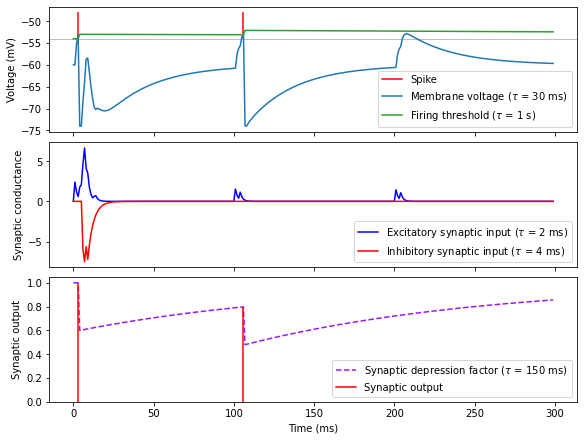

In [4]:
npulses = 3
legend_loc = 'lower right'
for j in sorting[:1]:
    u, v, th_adapt, xr, g_exc, g_inh = [
        np.concatenate([
            rundata['dynamics'][0]['A']['std'][k][j, p]
            for p in range(npulses)], axis=-1)
        for k in ('u','v','th_adapt','xr','g_exc','g_inh')]
    spikes = np.concatenate([
        rundata['spikes'][0]['A']['std']['pulsed_t'][p][rundata['spikes'][0]['A']['std']['pulsed_i'][p]==j] + p*params['ISI']
        for p in range(npulses)])
    time = np.arange(0*second, npulses*params['ISI']-params['dt']/2, params['dt'])

    fig, axs = plt.subplots(3, figsize=(8,6), sharex=True, constrained_layout=True)
    axs[0].axhline(params['v_threshold']/mV, color='grey', lw=1, alpha=.5)
    for spike in spikes:
        axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='r')
    axs[0].plot([], color='r', label='Spike')
    axs[0].plot(time/ms, v/mV, label='Membrane voltage ($\\tau$ = 30 ms)')
    axs[0].plot(time/ms, (th_adapt + params['v_threshold'])/mV, label='Firing threshold ($\\tau$ = 1 s)', c=colors['Threshold'])
    axs[0].legend(loc=legend_loc)
    axs[0].set_ylabel('Voltage (mV)')

    axs[1].plot(time/ms, g_exc, label='Excitatory synaptic input ($\\tau$ = 2 ms)', c='b')
    axs[1].plot(time/ms, -g_inh, label='Inhibitory synaptic input ($\\tau$ = 4 ms)', c='r')
    axs[1].legend(loc=legend_loc)
    axs[1].set_ylabel('Synaptic conductance')

    axs[2].plot(time/ms, xr, '--', c=colors['Depression'], label='Synaptic depression factor ($\\tau$ = 150 ms)')
    axs[2].vlines(spikes/ms, 0, xr[(((spikes+params['dt']/2))/params['dt']).astype(int)], color='r')
    axs[2].plot([], c='r', label='Synaptic output')
    axs[2].set_ylim(bottom=0)
    axs[2].legend(loc=legend_loc)
    axs[2].set_ylabel('Synaptic output')

    plt.xlabel('Time (ms)')

In [5]:
tslice = slice(90, None)

depression = u-v
threshold = th_adapt
activity = u-params['v_threshold']

v_noTA = params['v_threshold'] - v
v_noSTD = params['v_threshold']+th_adapt - u

def get_steps(mask):
    steps = np.flatnonzero(np.diff(mask[tslice])) + int(time[tslice][0]/ms) + 1
    if mask[tslice][0]:
        steps = np.concatenate([[0], steps])
    if mask[tslice][-1]:
        steps = np.concatenate([steps, [len(mask[tslice])]])
    return steps

steps = get_steps(activity > 0)
steps_noTA = get_steps(v_noTA < 0)
steps_noSTD = get_steps(v_noSTD < 0)

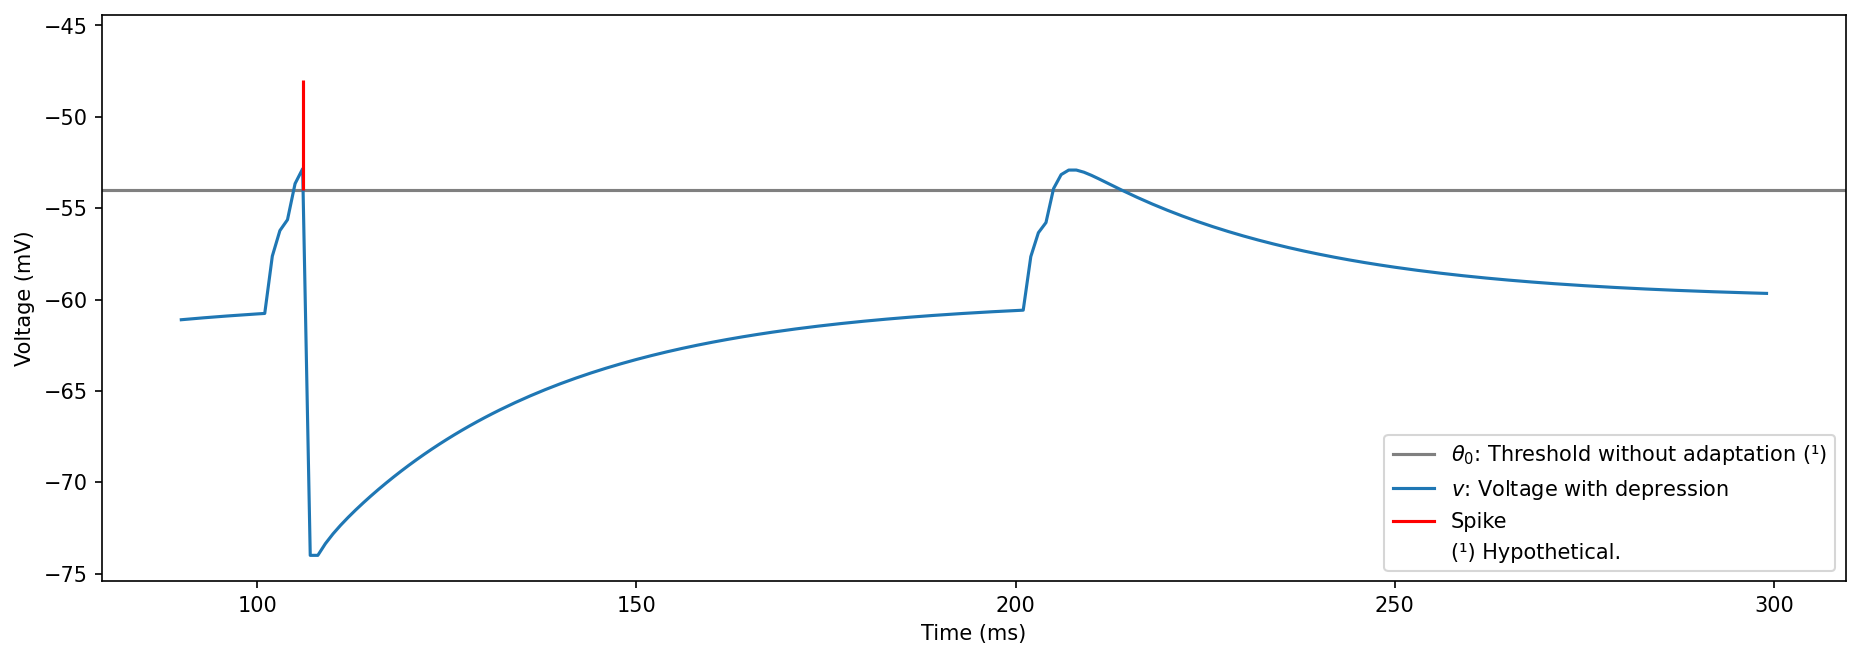

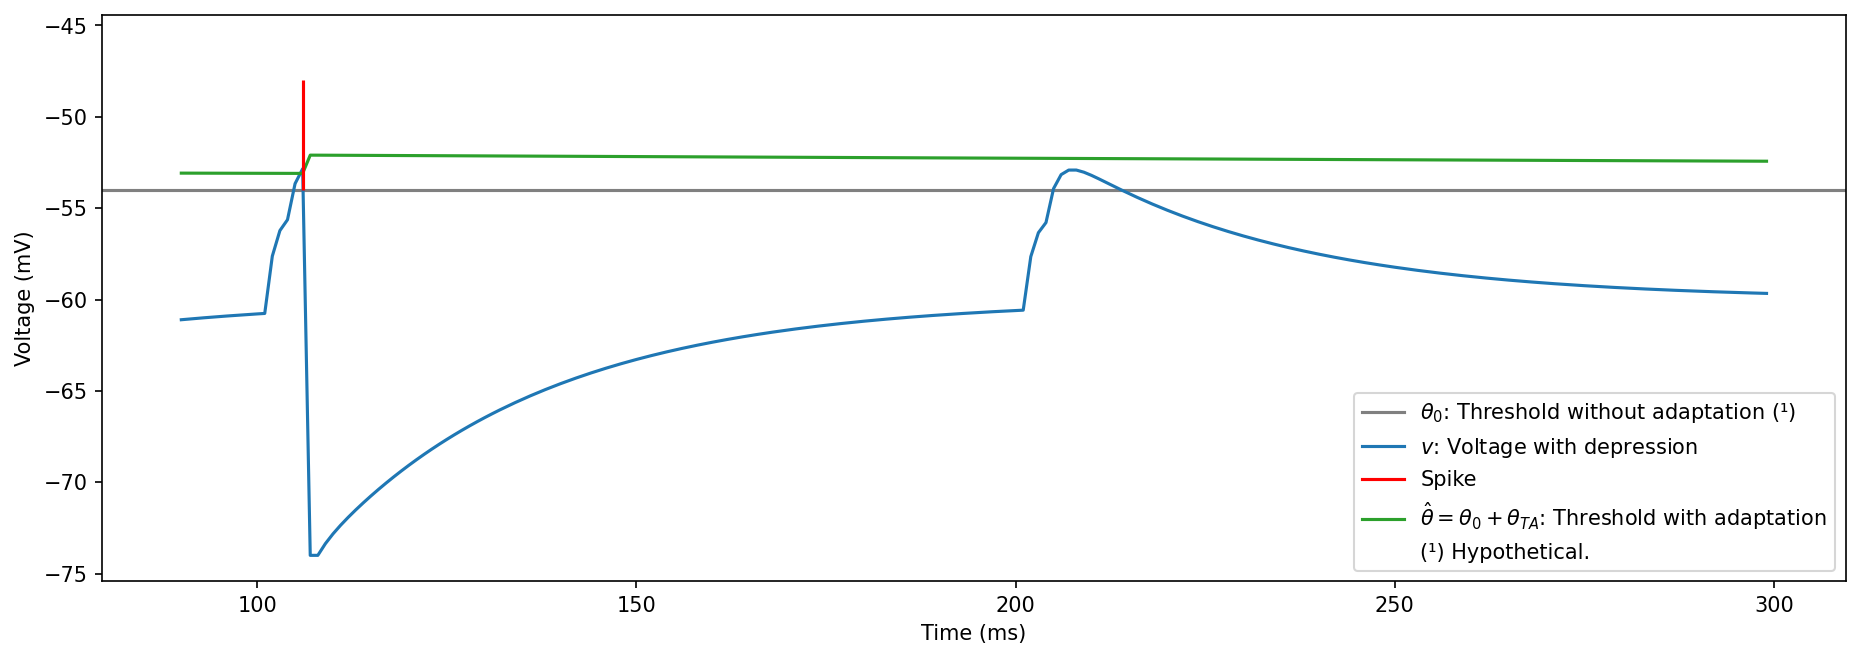

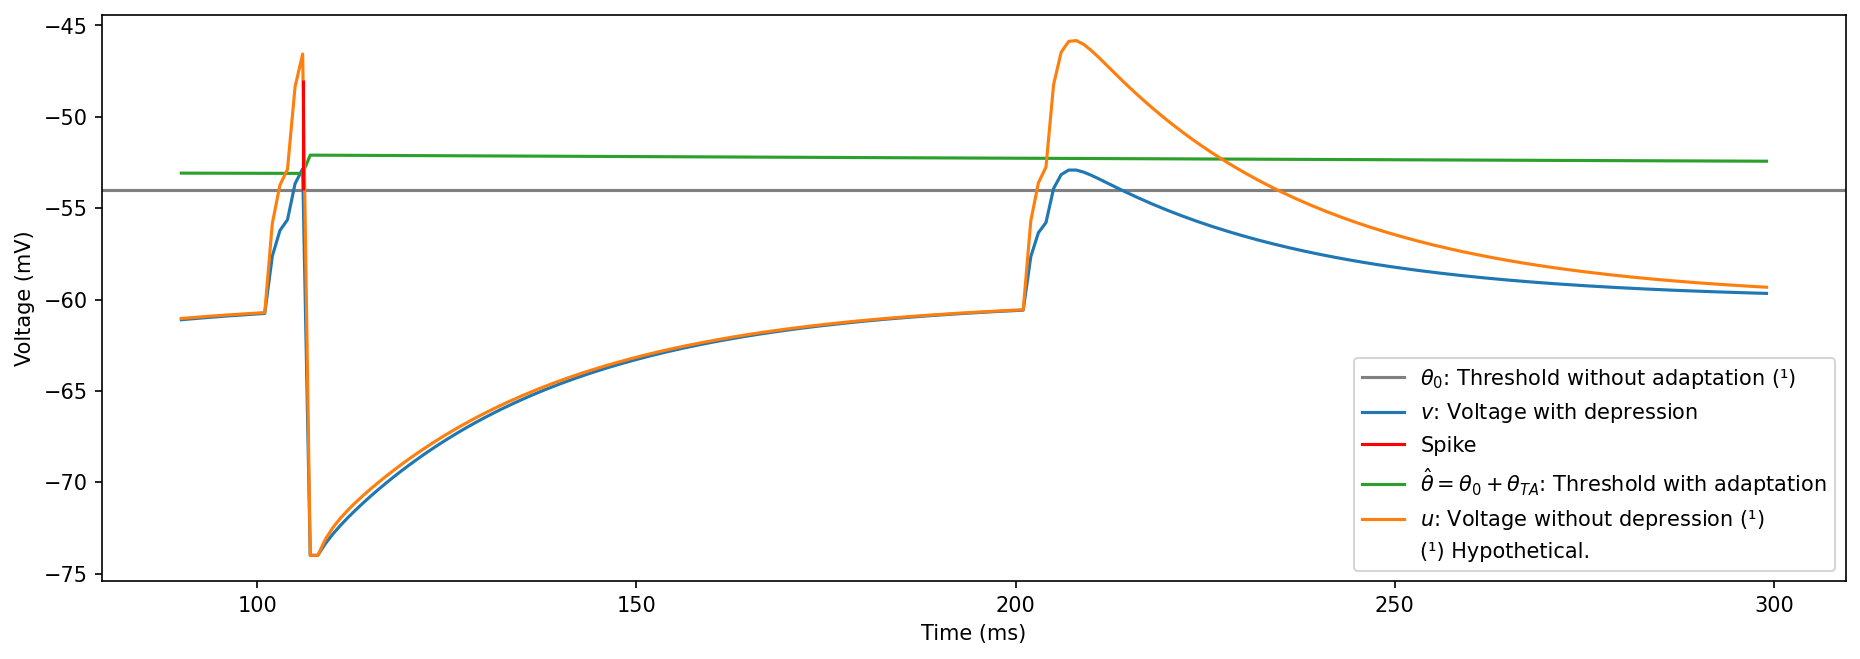

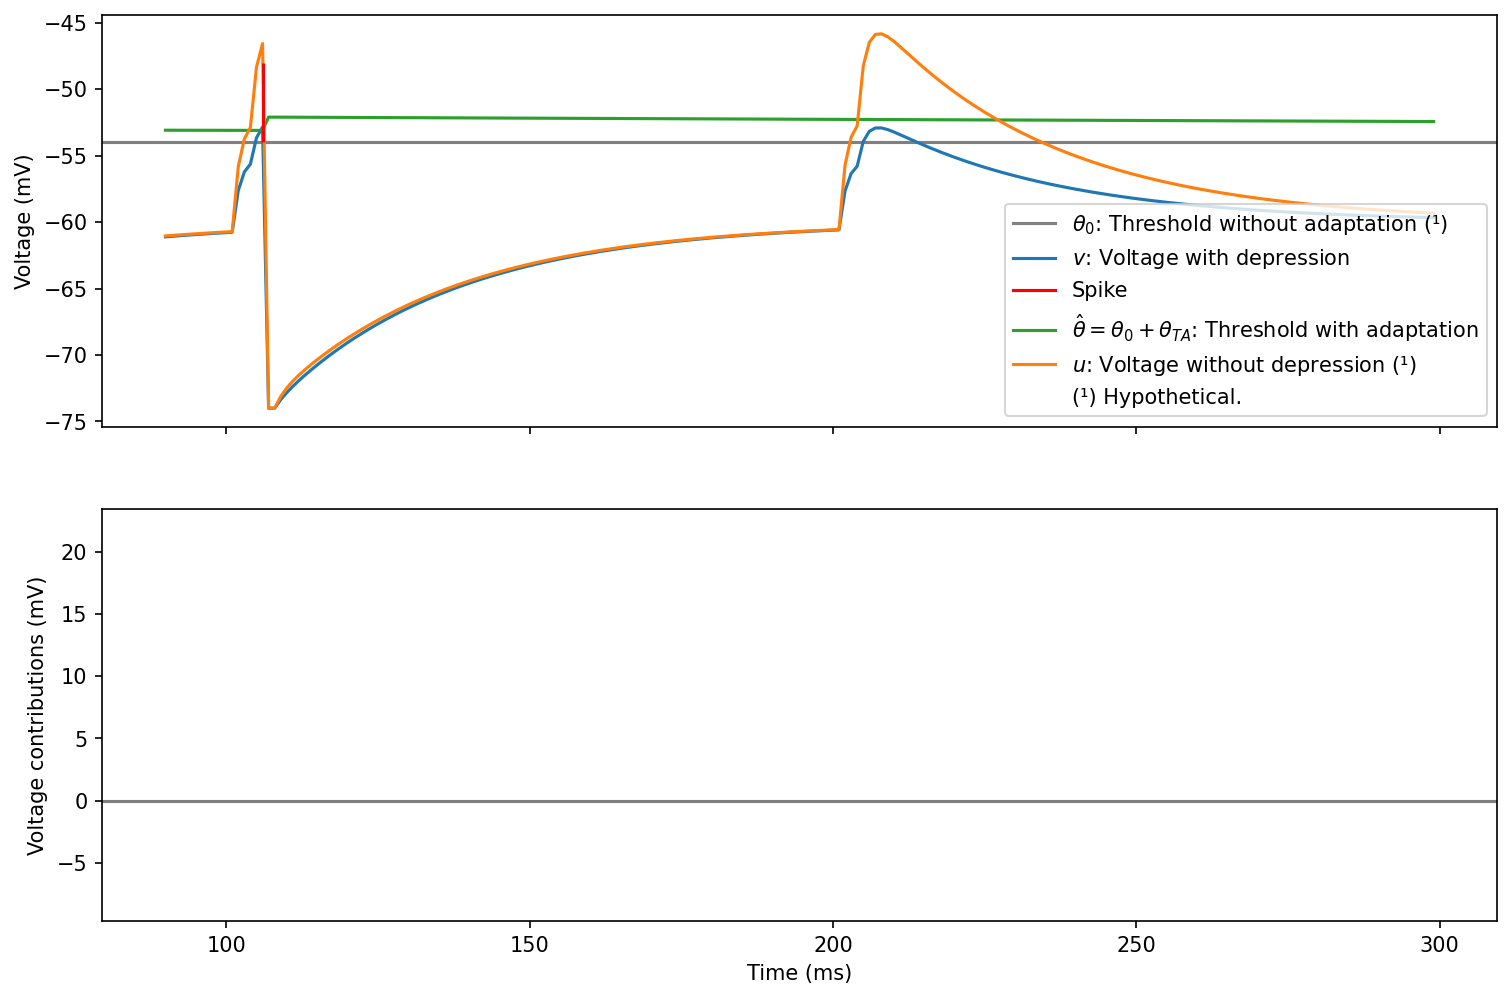

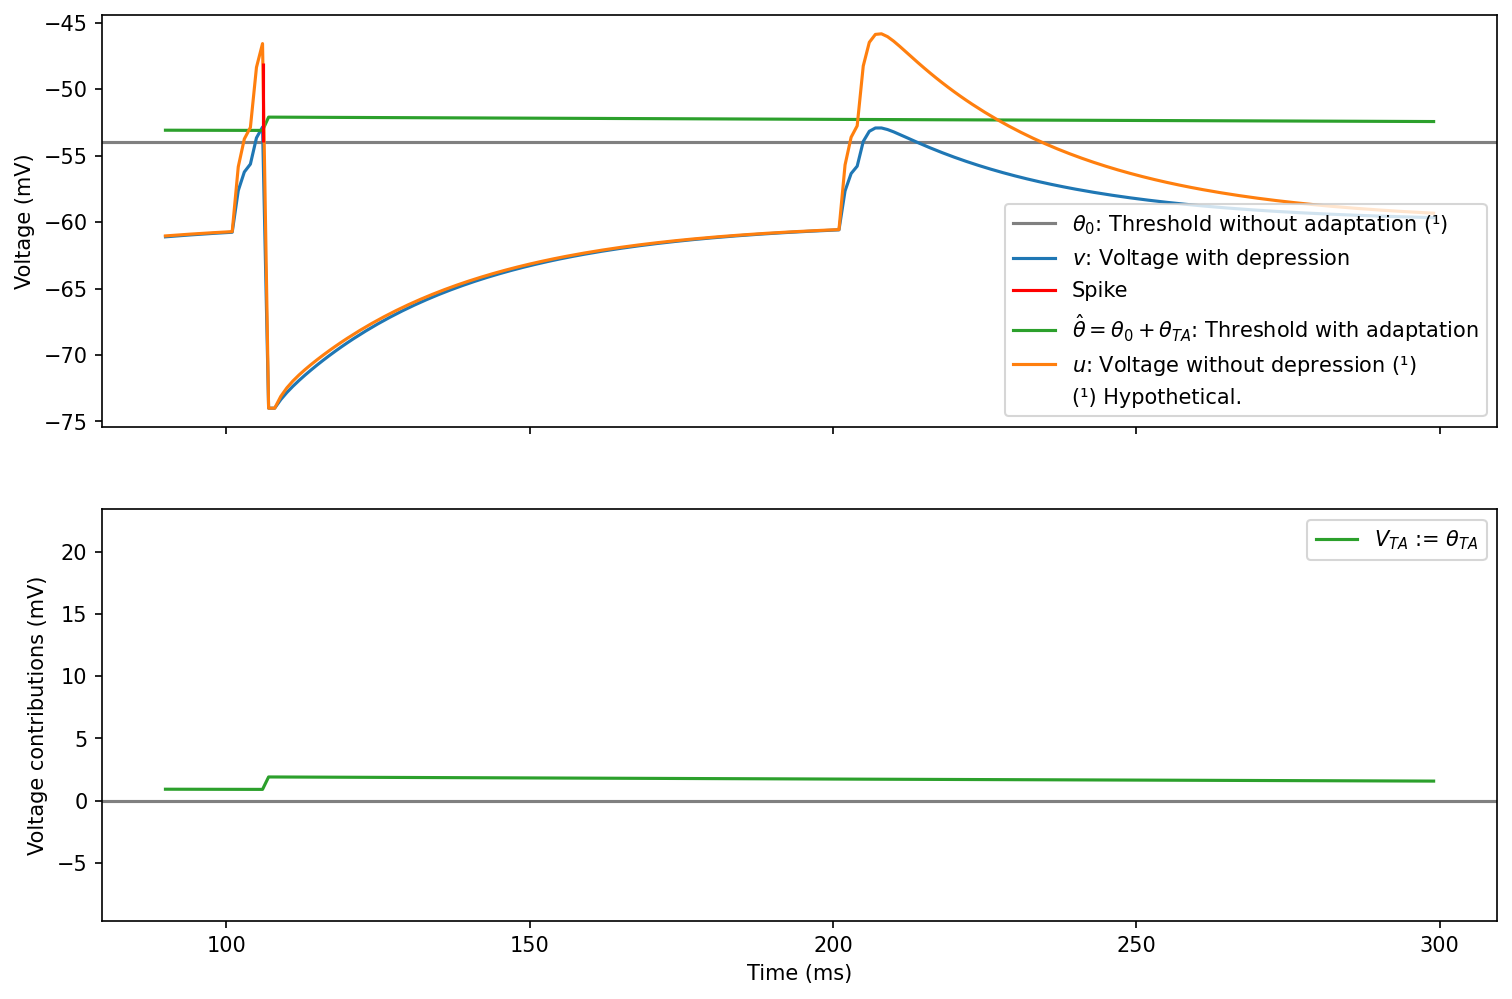

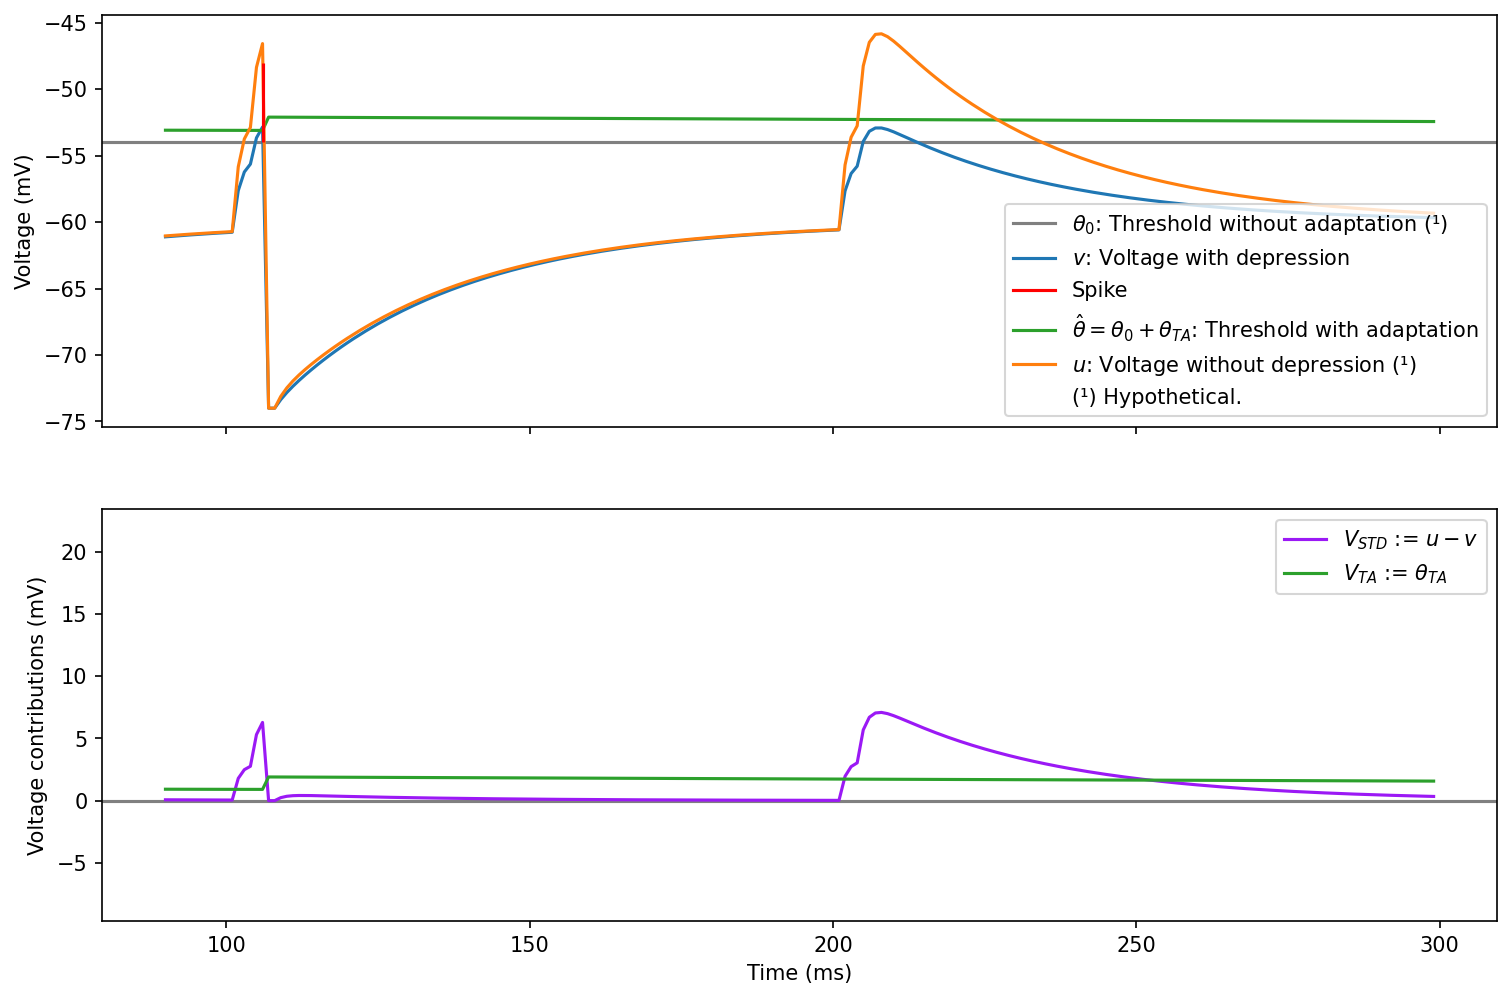

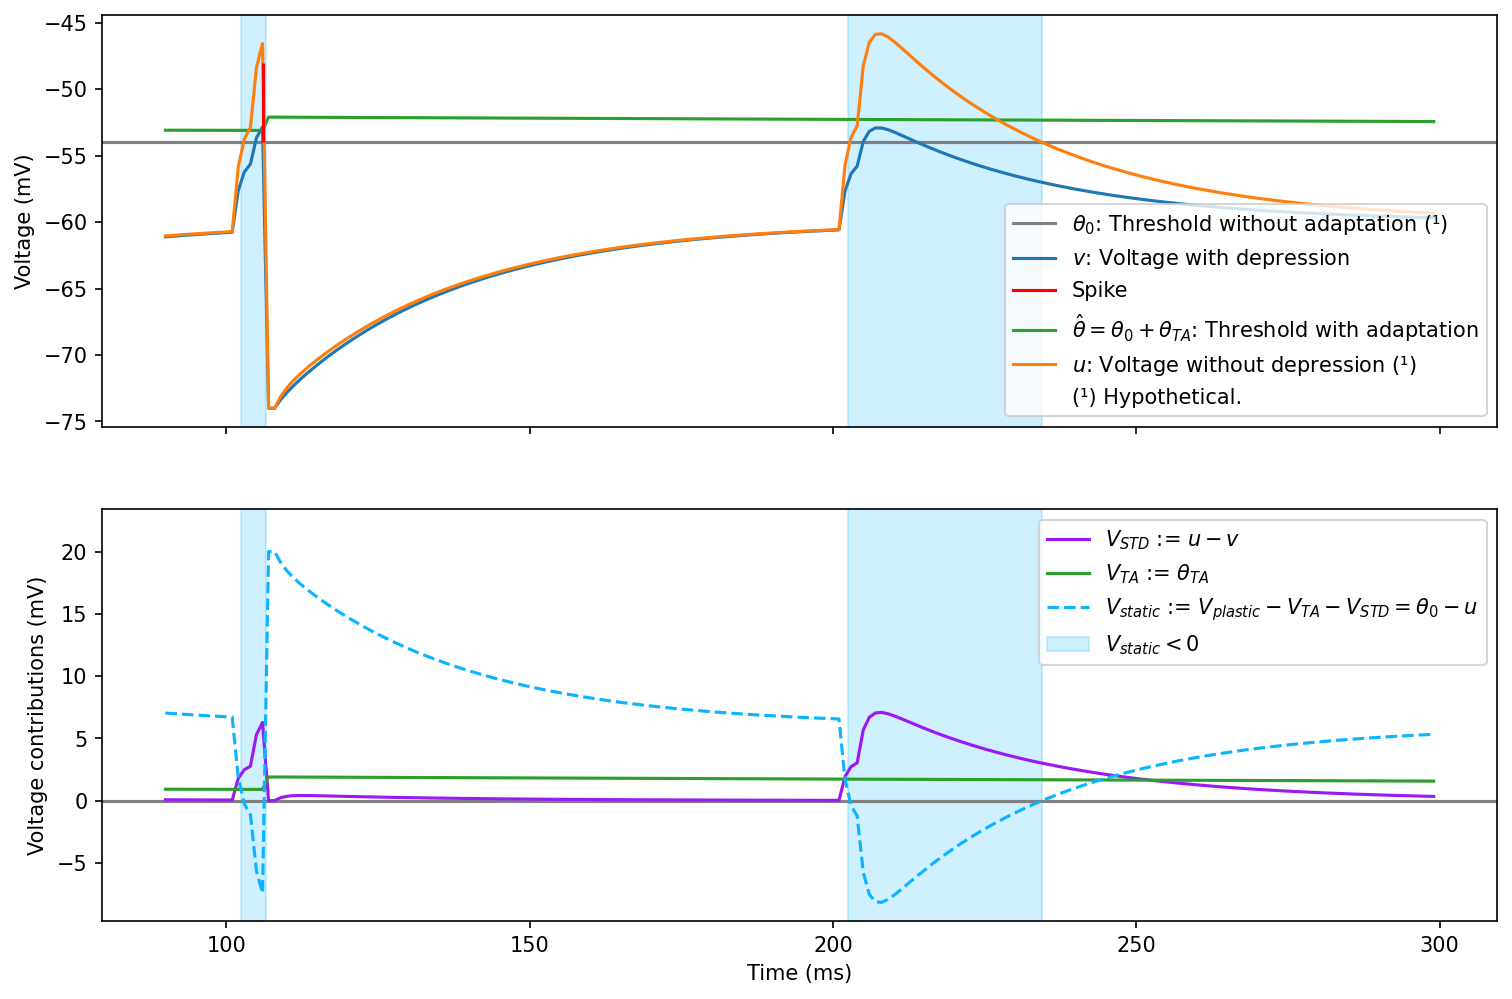

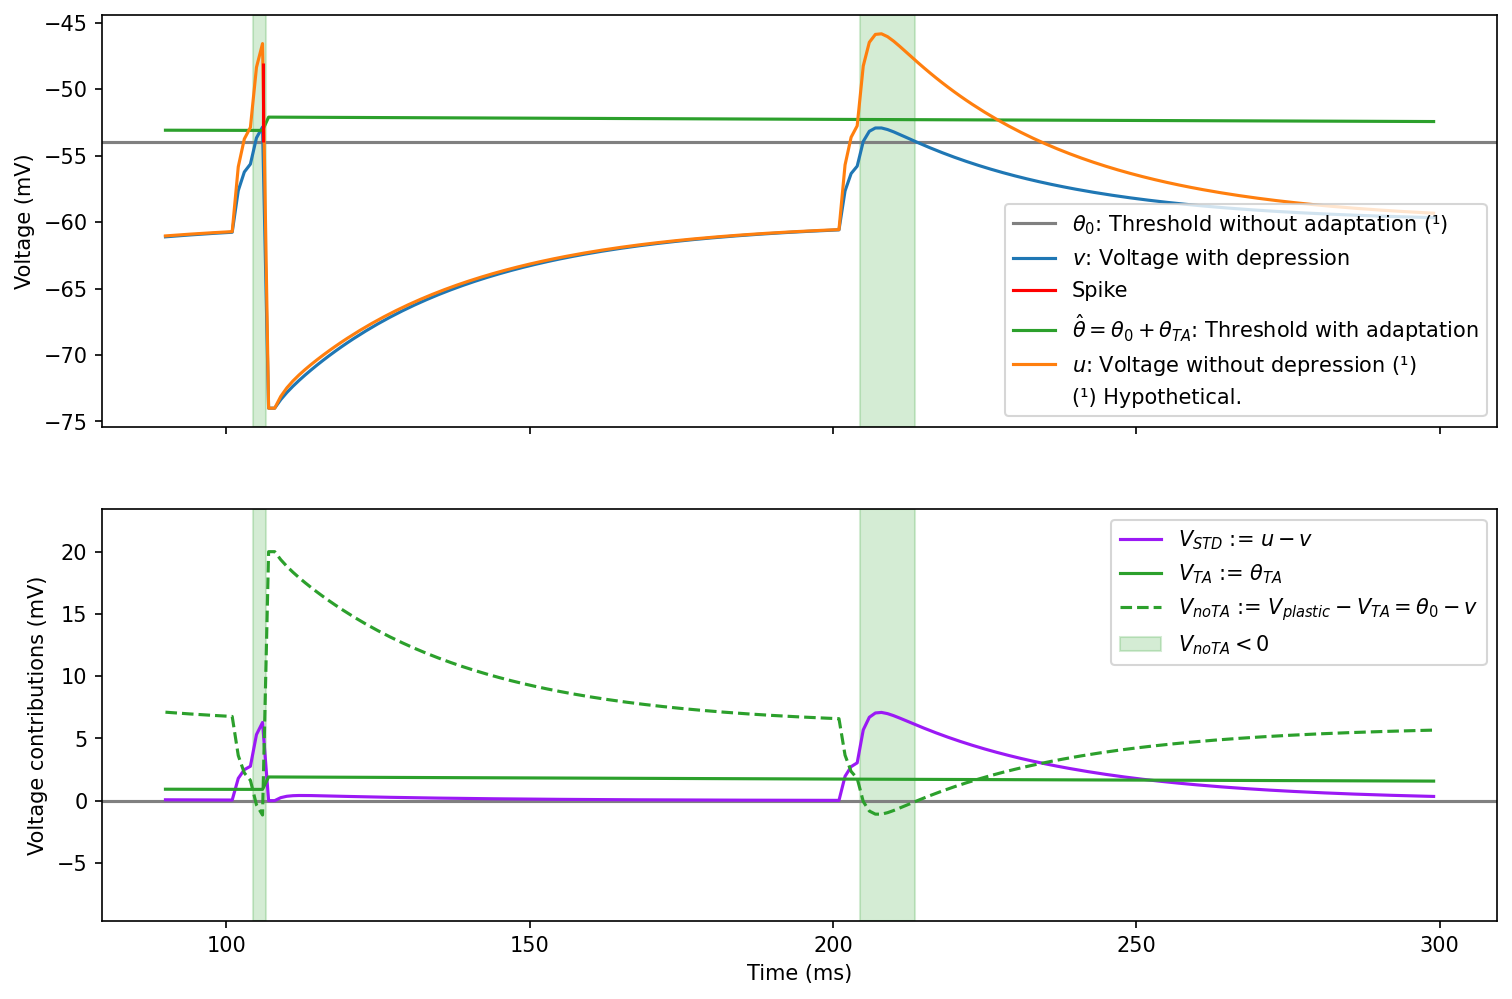

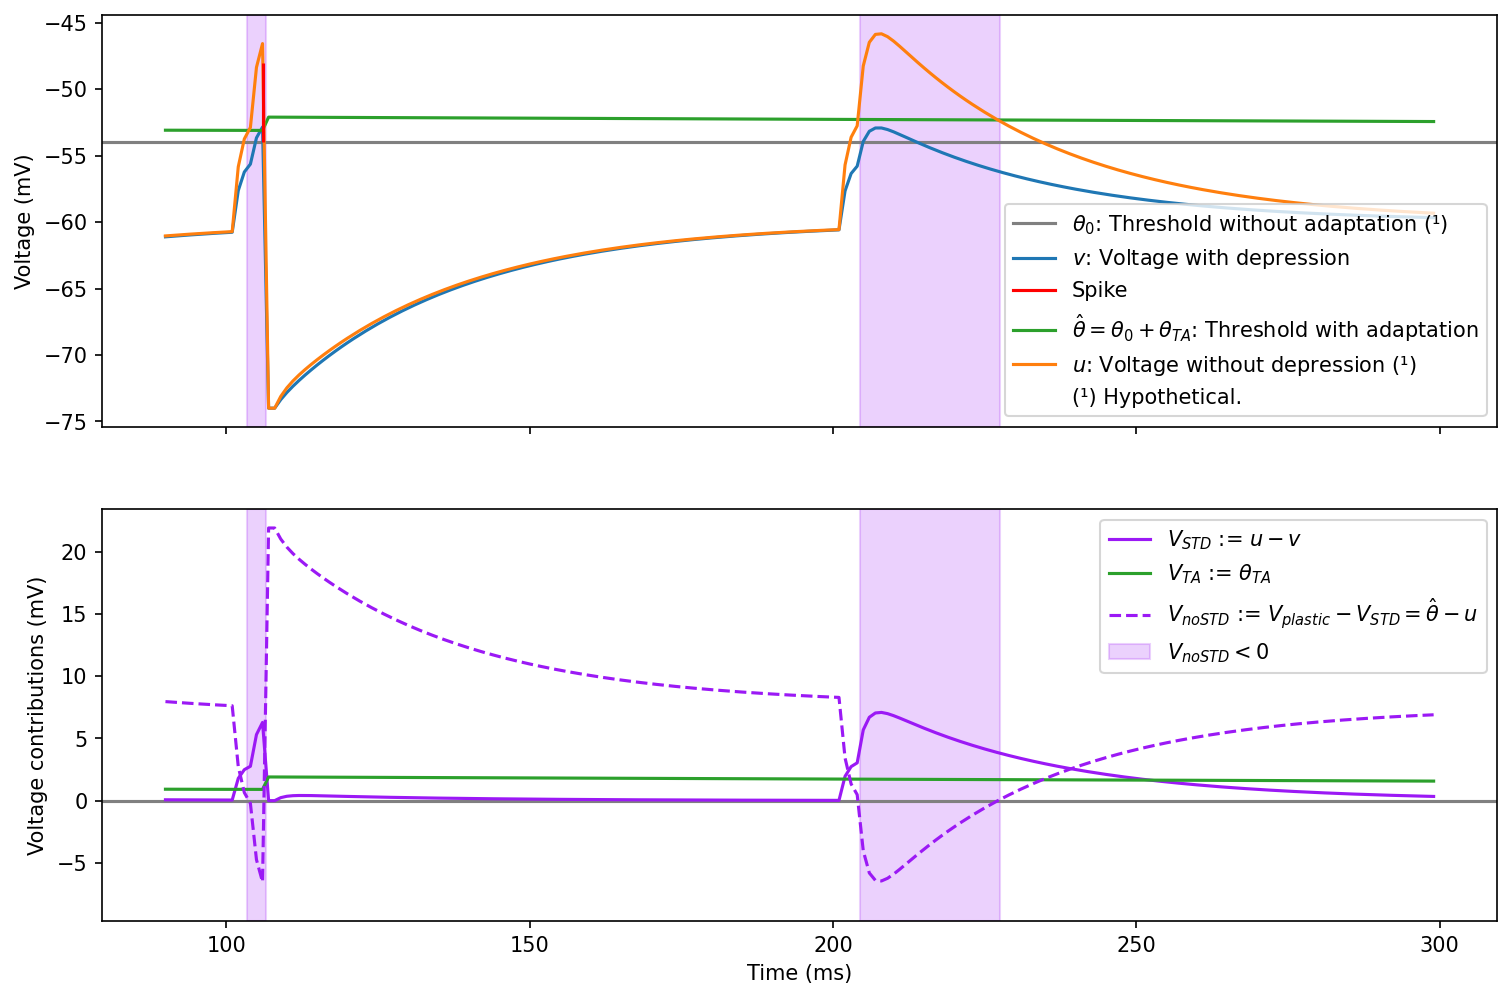

In [6]:
buildup = dict(zip(('static', 'TA', 'STD', 'panel2', 'p2-TA', 'p2-STD', 'mask', 'mask-TA', 'mask-STD'), itertools.count()))
for B in buildup.values():
    if B >= buildup['panel2']:
        fig, axs = plt.subplots(2, figsize=(12,8), sharex=True, dpi=150)
    else:
        fig, ax = plt.subplots(figsize=(15,5), dpi=150)
        axs = [ax]
    plt.xlabel('Time (ms)')

    axs[0].axhline((params['v_threshold'])/mV, label='$\\theta_0$: Threshold without adaptation (¹)', color='grey')
    axs[0].plot(time[tslice]/ms, v[tslice]/mV, label='$v$: Voltage with depression', color='C0')
    axs[0].plot([], label='Spike', color='r')
    if B >= buildup['TA']:
        axs[0].plot(time[tslice]/ms, (th_adapt[tslice] + params['v_threshold'])/mV,
                    label='$\\hat \\theta = \\theta_0+\\theta_{TA}$: Threshold with adaptation', color=colors['Threshold'])
    if B >= buildup['STD']:
        axs[0].plot(time[tslice]/ms, u[tslice]/mV, label='$u$: Voltage without depression (¹)', color='C1')
    for spike in spikes:
        if spike >= time[tslice][0] and spike <= time[tslice][-1]:
            axs[0].vlines(spike/ms, params['v_threshold']/mV, (params['v_rest']+2*(params['v_threshold']-params['v_rest']))/mV, color='r')
    axs[0].plot([], ls='', label='(¹) Hypothetical.')
    axs[0].legend(loc='lower right', fontsize=10)
    axs[0].set_ylabel('Voltage (mV)')
    lo, hi = (
        np.min([v[tslice], th_adapt[tslice]+params['v_threshold'], u[tslice]])/mV,
        np.max([v[tslice], th_adapt[tslice]+params['v_threshold'], u[tslice]])/mV)
    padding = 0.05*(hi-lo)
    axs[0].set_ylim(lo-padding, hi+padding)

    if B >= buildup['panel2']:
        axs[1].axhline(0, color='grey')
        if B >= buildup['p2-STD']:
            axs[1].plot(time[tslice]/ms, depression[tslice]/mV, c=colors['Depression'], label='$V_{STD}$ := $u-v$')
        if B >= buildup['p2-TA']:
            axs[1].plot(time[tslice]/ms, threshold[tslice]/mV, c=colors['Threshold'], label='$V_{TA}$ := $\\theta_{TA}$')
        axs[1].set_ylabel('Voltage contributions (mV)')
        lo, hi = (
            np.min([depression[tslice], threshold[tslice], -activity[tslice],
                    v_noTA[tslice], v_noSTD[tslice]])/mV,
            np.max([depression[tslice], threshold[tslice], -activity[tslice],
                    v_noTA[tslice], v_noSTD[tslice]])/mV)
        padding = 0.05*(hi-lo)
        axs[1].set_ylim(lo-padding, hi+padding)
    
    if B == buildup['mask']:
        axs[1].plot(time[tslice]/ms, -activity[tslice]/mV, ls='--', c='#0bb4ff', label='$V_{static}$ := $V_{plastic} - V_{TA} - V_{STD} = \\theta_0-u$')
        for up, down in steps.reshape(-1, 2):
            t_up, t_down = map(lambda x: (x*params['dt'] - params['dt']/2)/ms, (up, down))
            for ax in axs:
                ax.axvspan(t_up, t_down, color='#0bb4ff', alpha=.2, label='$V_{static} < 0$' if up==steps[0] else '')
    elif B == buildup['mask-TA']:
        axs[1].plot(time[tslice]/ms, v_noTA[tslice]/mV, ls='--', c=colors['Threshold'], label='$V_{noTA}$ := $V_{plastic} - V_{TA} = \\theta_0-v$')
        for up, down in steps_noTA.reshape(-1, 2):
            t_up, t_down = map(lambda x: (x*params['dt'] - params['dt']/2)/ms, (up, down))
            for ax in axs:
                ax.axvspan(t_up, t_down, color=colors['Threshold'], alpha=.2, label='$V_{noTA} < 0$' if up==steps_noTA[0] else '')
    elif B == buildup['mask-STD']:
        axs[1].plot(time[tslice]/ms, v_noSTD[tslice]/mV, ls='--', c=colors['Depression'], label='$V_{noSTD}$ := $V_{plastic} - V_{STD} = \\hat\\theta-u$')
        for up, down in steps_noSTD.reshape(-1, 2):
            t_up, t_down = map(lambda x: (x*params['dt'] - params['dt']/2)/ms, (up, down))
            for ax in axs:
                ax.axvspan(t_up, t_down, color=colors['Depression'], alpha=.2, label='$V_{noSTD} < 0$' if up==steps_noSTD[0] else '')
    
    if B > buildup['panel2']:
        axs[1].legend(loc='upper right', fontsize=10)